In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 读取数据
df = pd.read_csv('../datasets/WTH.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

df = df.iloc[0:24*30*(12+4+4)]
# 归一化
df = (df - df.min()) / (df.max() - df.min())


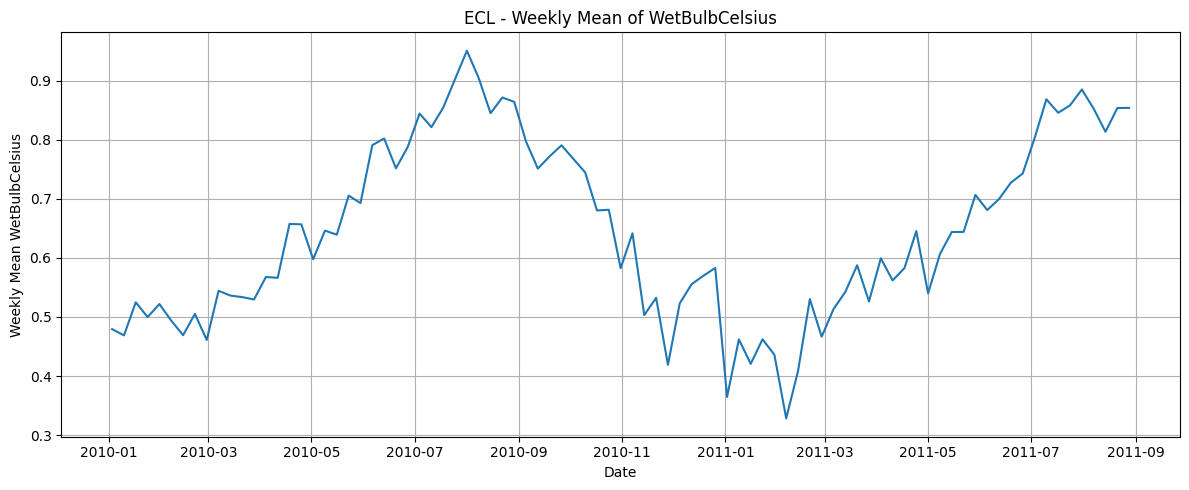

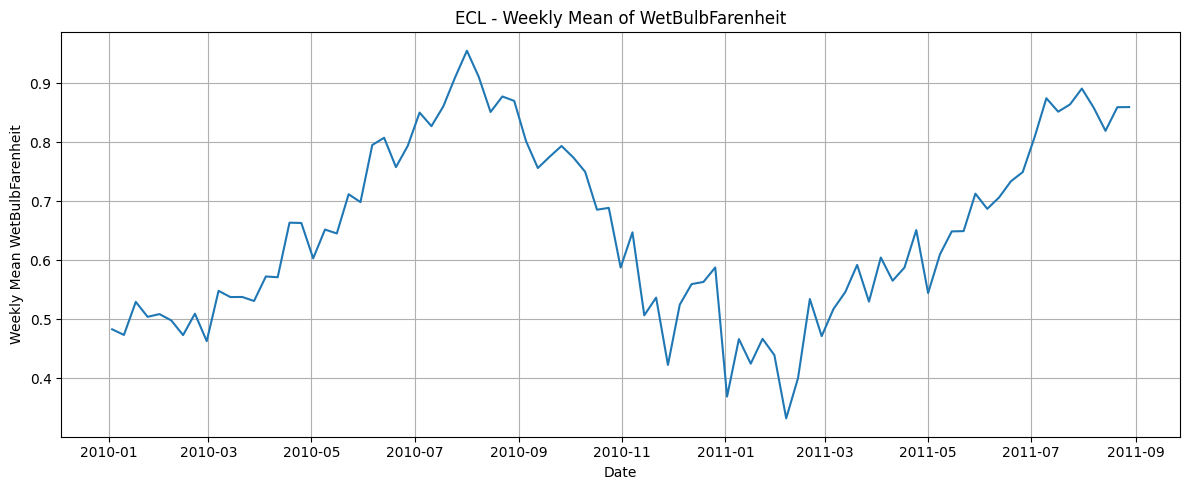

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def show_weekly_mean(df, target):
    # 2. 按每周重采样并求均值
    weekly_mean = df[target].resample('W').mean()

    # 3. 可视化
    plt.figure(figsize=(12, 5))
    plt.plot(weekly_mean)
    plt.title('ECL - Weekly Mean of {}'.format(target))
    plt.xlabel('Date')
    plt.ylabel('Weekly Mean {}'.format(target))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

show_weekly_mean(df, 'WetBulbCelsius')
show_weekly_mean(df, 'WetBulbFarenheit')


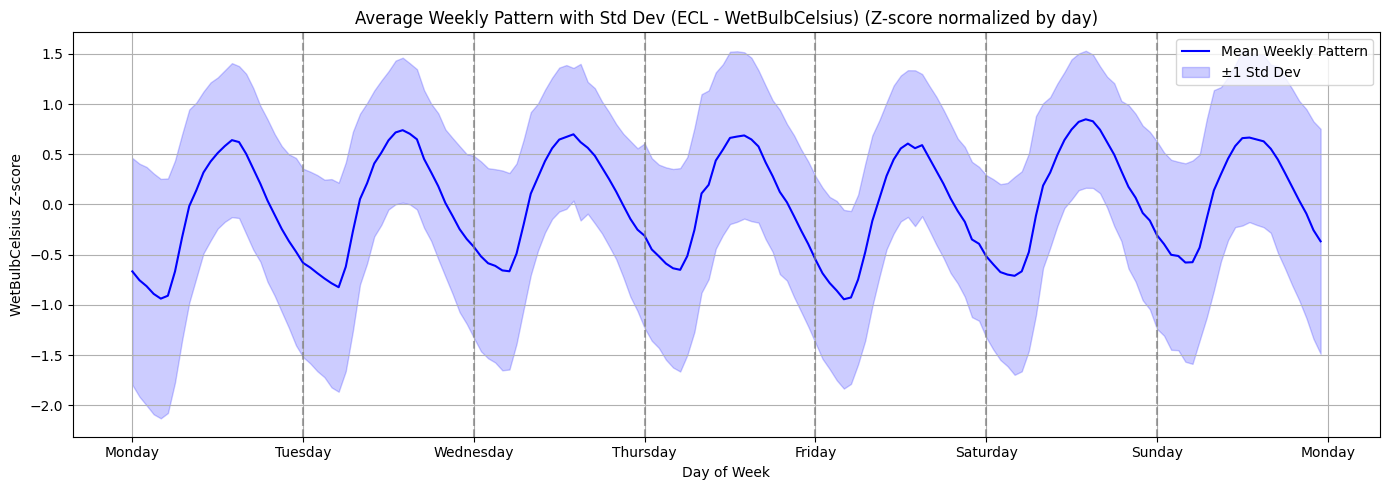

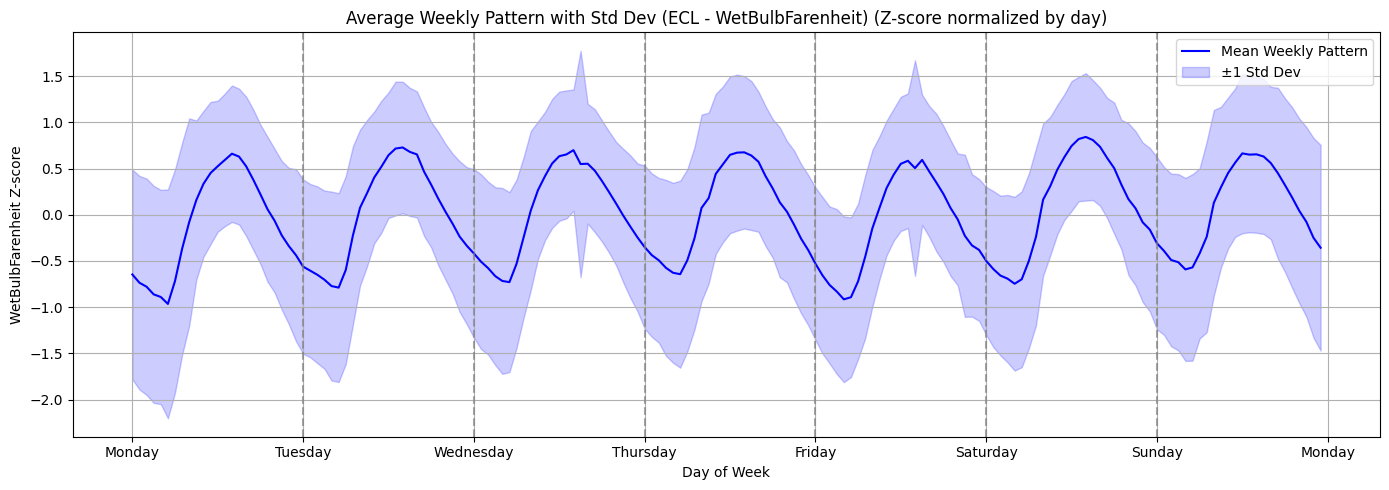

In [ ]:
def show_weekly_pattern(df, target, normalize_by_week=True):
    ot = df[target].values

    points_per_week = 168  # 7 days × 24 hours
    hours_per_day = 24
    num_weeks = len(ot) // points_per_week
    ot = ot[:num_weeks * points_per_week]  # truncate to complete weeks

    # Reshape to [weeks, 168 points per week]
    weekly_matrix = ot.reshape(num_weeks, points_per_week)
    
    weekly_means = weekly_matrix.mean(axis=1, keepdims=True)
    weekly_stds = weekly_matrix.std(axis=1, keepdims=True) + 1e-6
    weekly_norm = (weekly_matrix - weekly_means) / weekly_stds

    if normalize_by_week:
        mean_weekly_pattern = weekly_norm.mean(axis=0)
        std_weekly_pattern = weekly_norm.std(axis=0)
    else:
        # Calculate mean and std dev at each hour of the week
        mean_weekly_pattern = weekly_matrix.mean(axis=0)
        std_weekly_pattern = weekly_matrix.std(axis=0)
    
    # Visualization
    plt.figure(figsize=(14, 5))
    
    # Create day labels
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    # Create x-axis tick positions and labels
    tick_positions = [i * hours_per_day for i in range(8)]  # Start of each day + end
    tick_labels = days + ['Monday']  # Add Monday again to complete the cycle
    
    plt.plot(mean_weekly_pattern, label='Mean Weekly Pattern', color='blue')
    plt.fill_between(range(len(mean_weekly_pattern)),
                    mean_weekly_pattern - std_weekly_pattern,
                    mean_weekly_pattern + std_weekly_pattern,
                    color='blue', alpha=0.2, label='±1 Std Dev')
    
    # Set x-axis ticks and labels
    plt.xticks(tick_positions, tick_labels)
    
    # Add vertical lines to separate days
    for i in range(1, 7):
        plt.axvline(x=i*hours_per_day, color='gray', linestyle='--', alpha=0.7)
    
    title_suffix = " (Z-score normalized by day)" if normalize_by_week else ""
    plt.title(f'Average Weekly Pattern with Std Dev (ECL - {target}){title_suffix}')
    plt.xlabel('Day of Week')
    plt.ylabel(f'{target} Value' if not normalize_by_week else f'{target} Z-score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


show_weekly_pattern(df, 'MT_000', normalize_by_week=True)
show_weekly_pattern(df, 'MT_001', normalize_by_week=True)
show_weekly_pattern(df, 'MT_002', normalize_by_week=True)


In [15]:
def gaussian_kernel(size: int, sigma: float):
    """
    生成一维高斯核
    """
    x = np.arange(-size // 2 + 1, size // 2 + 1)
    kernel = np.exp(-x**2 / (2 * sigma**2))
    kernel = kernel / kernel.sum()
    return kernel
    
def gaussian_filter_nd(data: np.ndarray, kernel_size=5, sigma=1.0):
    """
    对 [N, D] 的数据逐列做高斯滤波
    """
    kernel = gaussian_kernel(kernel_size, sigma)
    padding = kernel_size // 2
    smoothed = np.zeros_like(data)

    # 对每一列做一维卷积（边缘填充）
    for d in range(data.shape[1]):
        padded = np.pad(data[:, d], pad_width=padding, mode='reflect')
        smoothed[:, d] = np.convolve(padded, kernel, mode='valid')
    
    return smoothed

class WeeklyPattern:
    def __init__(self, points_per_week=168, normalize_by_week=True, gauss_filter=False, kernel_size=5, sigma=1.0):
        
        self.points_per_week = points_per_week
        self.normalize_by_week = normalize_by_week
        self.mean_pattern = None  # [points_per_week, D]
        self.std_pattern = None   # [points_per_week, D]
        self.gauss_filter = gauss_filter
        self.kernel_size = kernel_size
        self.sigma = sigma


    def fit(self, data):  # data: [N, D]
        N, D = data.shape
        num_weeks = N // self.points_per_week
        data = data[:num_weeks * self.points_per_week]  # truncate to full weeks
        if self.gauss_filter:
            data = gaussian_filter_nd(data, kernel_size=self.kernel_size, sigma=self.sigma) # 高斯平滑
        weekly = data.reshape(num_weeks, self.points_per_week, D)  # [W, points_per_week, D]

        if self.normalize_by_week:
            # 按周归一化
            means = weekly.mean(axis=1, keepdims=True)  # [W, 1, D]
            stds = weekly.std(axis=1, keepdims=True) + 1e-6  # [W, 1, D]
            norm_weekly = (weekly - means) / stds
            self.mean_pattern = norm_weekly.mean(axis=0)  # [points_per_week, D]
            self.std_pattern = norm_weekly.std(axis=0)    # [points_per_week, D]
        else:
            # 全部按位置计算均值与方差
            self.mean_pattern = weekly.mean(axis=0)  # [points_per_week, D]
            self.std_pattern = weekly.std(axis=0)    # [points_per_week, D]

    # 可视化
    def plot(self, title='Weekly Pattern'):
        D = self.mean_pattern.shape[1]
        for d in range(D):
            plt.figure(figsize=(14, 5))
            plt.plot(self.mean_pattern[:, d], label='Mean Weekly Pattern', color='blue')
            plt.fill_between(range(len(self.mean_pattern)),
                             self.mean_pattern[:, d] - self.std_pattern[:, d],
                             self.mean_pattern[:, d] + self.std_pattern[:, d],
                             color='blue', alpha=0.2, label='±1 Std Dev')

            # Create day labels
            days = ['0', '1', '2', '3', '4', '5', '6', '7']

            # Create x-axis tick positions and labels
            tick_positions = [i * 24 for i in range(8)]  # Start of each day + end
            tick_labels = days

            # Set x-axis ticks and labels
            plt.xticks(tick_positions, tick_labels)
            
            # Add vertical lines to separate days
            for i in range(1, 7):
                plt.axvline(x=i*24, color='gray', linestyle='--', alpha=0.7)
            
            plt.title(title)
            plt.xlabel('Day of Week, dimension {}'.format(d))
            plt.ylabel('Z-score' if self.normalize_by_week else 'Value')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    def get_pattern(self, start_idx, end_index, base_pattern=None):
        """
        [start_idx, end_index) -> [end_index - start_idx, D]
        """
        if base_pattern is None:
            base_pattern = self.mean_pattern

        start_b, start_i = start_idx // self.points_per_week, start_idx % self.points_per_week
        end_b, end_i = end_index // self.points_per_week, end_index % self.points_per_week
        if start_b == end_b:
            return base_pattern[start_i:end_i]
        elif start_b + 1 == end_b:
            pattern = np.concatenate([base_pattern[start_i:], base_pattern[:end_i]], axis=0)
            return pattern
        else:
            repeat = end_b - start_b - 1
            start_part = base_pattern[start_i:]
            middle_part = np.tile(base_pattern, (repeat, 1))
            end_part = base_pattern[:end_i]
            pattern = np.concatenate([start_part, middle_part, end_part], axis=0)
            return pattern

    def get_pattern_with_input(self, input_data, s_i, s_j, s_k, alpha=0.5):
        """
        结合全局周模式和当前输入数据的局部特征，生成混合模式预测
        
        参数:
            input_data: [s_j - s_i, D] 输入序列数据
            s_i: 输入数据的开始索引
            s_j: 输入数据的结束索引（同时也是预测的开始索引）
            s_k: 预测的结束索引
            alpha: 混合参数，控制全局模式和局部模式的权重，范围[0,1]
                alpha=1 表示只使用全局模式，alpha=0 表示只使用局部模式
        
        返回:
            混合的模式预测 [s_k - s_j, D]
        """
        input_length = input_data.shape[0]

        # get global pattern
        global_pattern = self.get_pattern(s_j, s_k)
        # scale to input (mean, std)
        last_num = int(self.points_per_week * 1.0)
        in_mean, in_std = input_data[-last_num:].mean(axis=0), input_data[-last_num:].std(axis=0) + 1e-6
        global_pattern = global_pattern * in_std + in_mean
        
        # check
        expected_length = s_j - s_i
        if input_data.shape[0] != expected_length:
            raise ValueError(f"输入数据长度 {input_data.shape[0]} 与预期长度 {expected_length} 不符")
        
        
        assert input_length >= self.points_per_week, f"输入数据长度 {input_length} 小于每周点数 {self.points_per_week}"
        
        # calc local_pattern [points_per_week, D]
        local_pattern = np.zeros((self.points_per_week, input_data.shape[1]))
        num_repeats = input_length // self.points_per_week
        for i in range(num_repeats * self.points_per_week):
            local_pattern[(s_i + i) % self.points_per_week] += input_data[i]
        local_pattern /= num_repeats

        local_pattern = self.get_pattern(s_j, s_k, local_pattern)
        local_pattern = gaussian_filter_nd(local_pattern, kernel_size=self.kernel_size, sigma=self.sigma) # 高斯平滑
        # print("local pattern shape", local_pattern.shape)
        # print("global pattern shape", global_pattern.shape)
        # mix
        mixed_pattern = alpha * global_pattern + (1 - alpha) * local_pattern
        
        return mixed_pattern

    def transform(self, data, start_idx, end_index):
        """
        data: [L, D]
        L = end_index - start_idx
        """
        assert data.shape[0] == end_index - start_idx
        pat = self.get_pattern(start_idx, end_index)
        return data - pat
    def inverse_transform(self, data, start_idx, end_index):
        """
        data: [L, D]
        L = end_index - start_idx
        """
        assert data.shape[0] == end_index - start_idx
        pat = self.get_pattern(start_idx, end_index)
        return data + pat

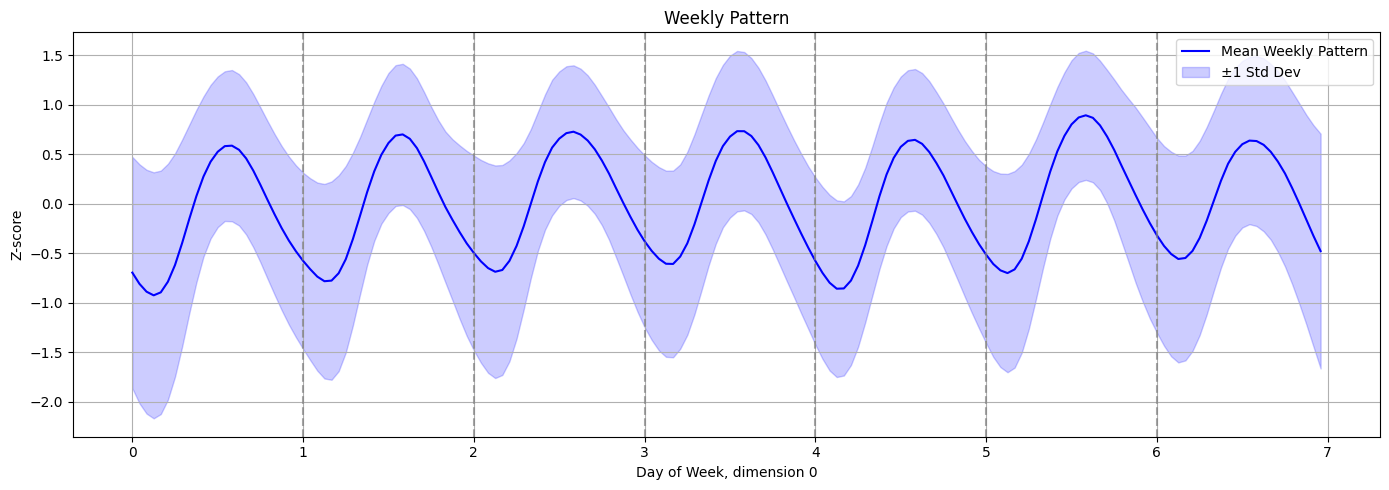

In [17]:
pattern = WeeklyPattern(normalize_by_week=True, gauss_filter=True, kernel_size=7, sigma=2.3)
pattern.fit(df[['WetBulbCelsius']].values[:12*30*24])
pattern.plot()


(168, 1)
MSE: 0.0232, MAE: 0.1112


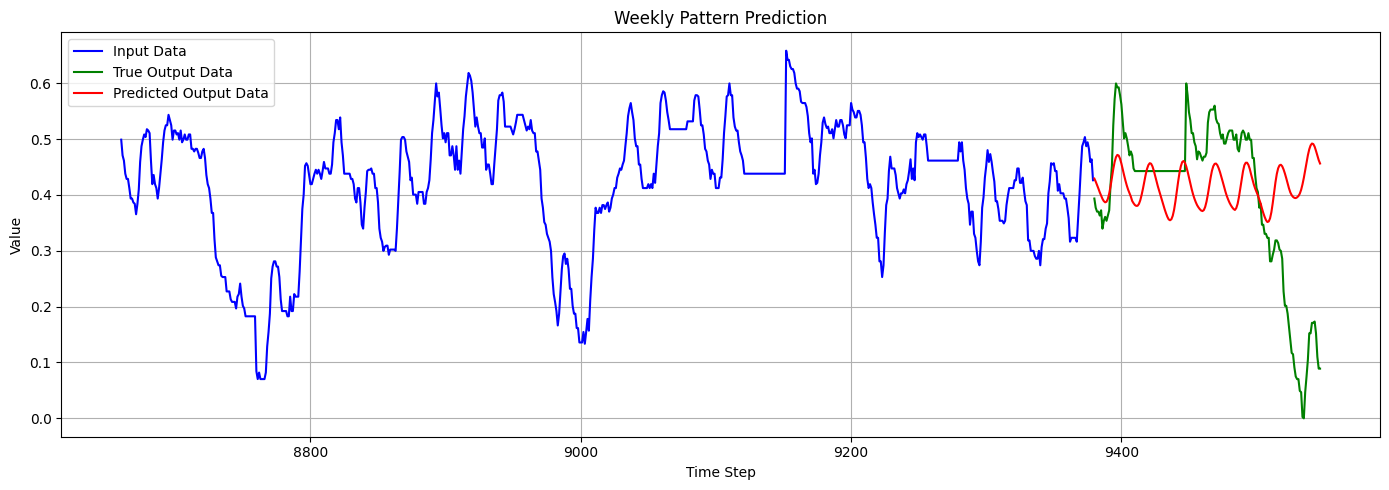

In [19]:
test_data = df[['WetBulbCelsius']].values
start = 24*30*12 + 20
in_len = 720
out_len = 168

s_i, s_j, s_k = start, start + in_len, start + in_len + out_len
in_data = test_data[s_i:s_j]
out_data = test_data[s_j:s_k]
pat = pattern.get_pattern_with_input(in_data, s_i, s_j, s_k, alpha=0.5)
print(pat.shape)

plt.figure(figsize=(14, 5))
plt.plot(range(s_i, s_j), in_data, label='Input Data', color='blue')
plt.plot(range(s_j, s_k), out_data, label='True Output Data', color='green')
plt.plot(range(s_j, s_k), pat, label='Predicted Output Data', color='red')
mse = np.mean((out_data - pat) ** 2)
mae = np.mean(np.abs(out_data - pat))
print(f'MSE: {mse:.4f}, MAE: {mae:.4f}')
plt.title('Weekly Pattern Prediction')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# 1 : MSE: 0.0056, MAE: 0.0609 

# 高斯滤波

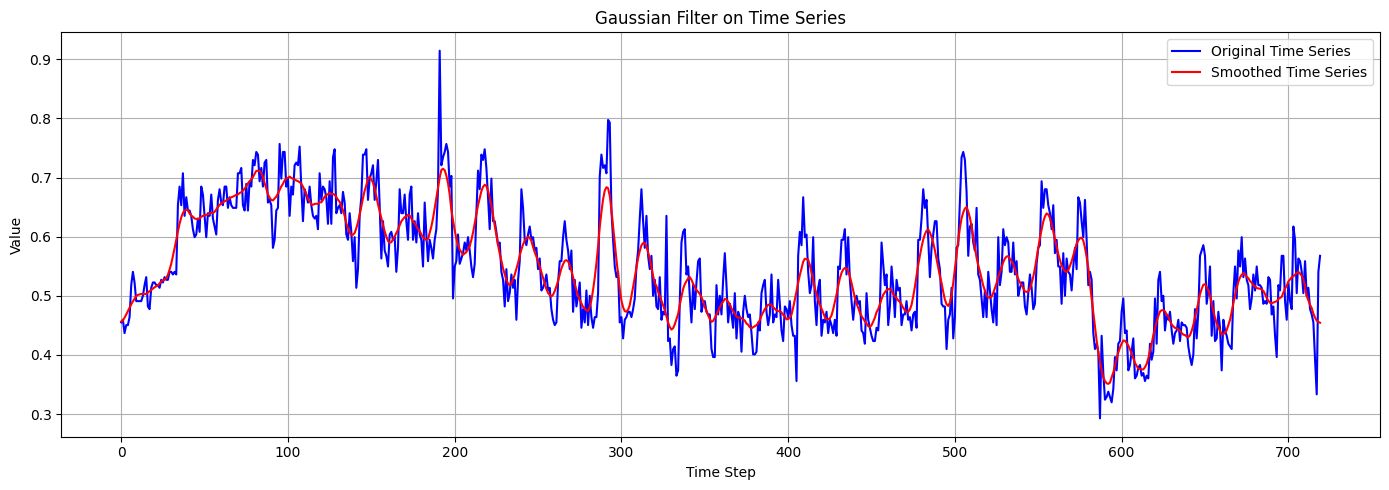

In [ ]:
import numpy as np

def gaussian_kernel(size: int, sigma: float):
    """
    生成一维高斯核
    """
    x = np.arange(-size // 2 + 1, size // 2 + 1)
    kernel = np.exp(-x**2 / (2 * sigma**2))
    kernel = kernel / kernel.sum()
    return kernel


def gaussian_filter_nd(data: np.ndarray, kernel_size=5, sigma=1.0):
    """
    对 [N, D] 的数据逐列做高斯滤波
    """
    kernel = gaussian_kernel(kernel_size, sigma)
    padding = kernel_size // 2
    smoothed = np.zeros_like(data)

    # 对每一列做一维卷积（边缘填充）
    for d in range(data.shape[1]):
        padded = np.pad(data[:, d], pad_width=padding, mode='reflect')
        smoothed[:, d] = np.convolve(padded, kernel, mode='valid')
    
    return smoothed
# 示例用法：
ts = df[['HULL']].values[:720]
smoothed = gaussian_filter_nd(ts, kernel_size=13, sigma=4)

plt.figure(figsize=(14, 5))
plt.plot(ts, label='Original Time Series', color='blue')
plt.plot(smoothed, label='Smoothed Time Series', color='red')
plt.title('Gaussian Filter on Time Series')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
